In [11]:
import matplotlib.pyplot as plt
from datasets.PupilCoreDatasetIfOpened import PupilCoreDatasetIfOpened
from datasets.PupilCoreDatasetPupil import PupilCoreDatasetPupil
from datasets.PupilCoreDatasetCornealReflection import PupilCoreDatasetCornealReflection
from models.ifOpened import ifOpenedModel
from models.pupilDetectModel import PupilDetectModel
from models.utils import train_first_model
import models.utils as utils
import torch
from torch import nn
from torch.optim import lr_scheduler
import torch.optim as optim
import time
import copy
from torchvision import models
import numpy as np
import cv2


In [4]:
# dataset = PupilCoreDatasetIfOpened(
#     "datasets/PupilCoreDataset/video5_eye0_video.avi",
#     'datasets/PupilCoreDataset/video5_eye0_pupildata.csv',
#     "datasets/PupilCoreDataset/video5_eye1_video.avi",
#     'datasets/PupilCoreDataset/video5_eye1_pupildata.csv'
# )

In [5]:
# indices = torch.randperm(len(dataset)).tolist()
# train_part = int(0.8 * len(dataset))
# train_dataset = torch.utils.data.Subset(dataset, indices[:train_part])
# test_dataset = torch.utils.data.Subset(dataset, indices[train_part:])
# dataset_sizes = {
#     'train': len(train_dataset),
#     'test': len(test_dataset)
# }

# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
# dataloaders = {
#     "train": train_dataloader,
#     "test": test_dataloader
# }

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
# model = ifOpenedModel()
# model.to(device)

In [8]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# model = train_first_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=2, dataloaders=dataloaders, dataset_sizes=dataset_sizes, device=device)

In [9]:
# model for datasetCoords.py
model_pupil = models.resnet18(pretrained=False)
model_pupil.fc = nn.Linear(in_features=512, out_features=2, dtype=torch.float32)
# model_pupil = PupilDetectModel()

model_pupil

c:\Users\Admin\Desktop\inzynierka\my_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\Desktop\inzynierka\my_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
dataset_pupil = PupilCoreDatasetPupil(
    "datasets/PupilCoreDataset/video5_eye0_video.avi",
    'datasets/PupilCoreDataset/video5_eye0_pupildata.csv',
    "datasets/PupilCoreDataset/video5_eye1_video.avi",
    'datasets/PupilCoreDataset/video5_eye1_pupildata.csv'
)
indices = torch.randperm(len(dataset_pupil)).tolist()
train_part = int(0.8 * len(dataset_pupil))
train_dataset = torch.utils.data.Subset(dataset_pupil, indices[:train_part])
test_dataset = torch.utils.data.Subset(dataset_pupil, indices[train_part:])
dataset_sizes = {
    'train': len(train_dataset),
    'test': len(test_dataset)
}

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
dataloaders = {
    "train": train_dataloader,
    "test": test_dataloader
}

In [15]:
def train_second_model(
    model,
    criterion,
    optimizer,
    scheduler,
    num_epochs,
    device,
    dataloaders,
    dataset_sizes,
):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    model = model.to(device)
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "test"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.01
            running_corrects = 0
            losses = []

            # Iterate over data.
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    # print(outputs, labels)
                    outputs.to(device)
                    
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                losses.append(loss.item())
                # print(running_loss)

                if i % 500 == 0:
                    print(f"{phase}, Batch: {i}/{len(dataloaders[phase])} Loss: {np.mean(losses):.4f}")
            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            # epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            
            # deep copy the model
            # if phase == "test" and epoch_acc > best_acc:
            #     best_acc = epoch_acc
            #     best_model_wts = copy.deepcopy(model.state_dict())
    return model

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model_pupil.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_pupil = train_second_model(model_pupil, criterion, optimizer, exp_lr_scheduler, num_epochs=5, dataloaders=dataloaders, dataset_sizes=dataset_sizes, device=device)

In [20]:
def visualize(model, dataloader, device, num_images: int = 5):
    model.eval()
    fig = plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            
            center_out = list(map(int, outputs[0].cpu().numpy()))
            center_labels = list(map(int, labels[0].cpu().numpy()))
            print(f"center_out: {center_out}", f"center_label: {center_labels}")
            image = np.transpose(inputs[0].cpu().numpy(), (1, 2, 0)).copy()
            
            # fig.add_subplot(1, num_images, i+1)
            cv2.circle(image, center_out, 1, (255, 0, 0), 1)
            cv2.circle(image, center_labels, 1, (0, 255, 0), 1)
            plt.imshow(image)
            plt.show()
            #cv2.imshow("xd", image)
            if i >= num_images:
                
                return

                
# visualize_pupil(model_pupil, dataloaders['test'], device, 5)

In [17]:
def evaluate(model, dataloaders, device, dataset_sizes):
    model.eval()
    correct = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["test"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            # print(outputs, labels)
            diff = (labels[0][0] - outputs[0][0], labels[0][1] - outputs[0][1])
            # print(diff)
            dist = torch.sqrt(torch.pow(diff[0], 2) + torch.pow(diff[0], 2)) 
            if dist < 2: 
                correct += 1
        
        acc = correct / dataset_sizes['test']
        print(acc)


In [ ]:
evaluate(model_pupil, dataloaders, device, dataset_sizes)

In [12]:
dataset_corneal = PupilCoreDatasetCornealReflection(
    "datasets/PupilCoreDataset/video5_eye0_video.avi",
    'datasets/PupilCoreDataset/video5_eye0_pupildata.csv',
    "datasets/PupilCoreDataset/video5_eye1_video.avi",
    'datasets/PupilCoreDataset/video5_eye1_pupildata.csv'
)
indices = torch.randperm(len(dataset_corneal)).tolist()
train_part = int(0.8 * len(dataset_corneal))
train_dataset = torch.utils.data.Subset(dataset_corneal, indices[:train_part])
test_dataset = torch.utils.data.Subset(dataset_corneal, indices[train_part:])
dataset_sizes = {
    'train': len(train_dataset),
    'test': len(test_dataset)
}

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
dataloaders = {
    "train": train_dataloader,
    "test": test_dataloader
}

can't receive frame
can't receive frame


In [16]:
#TODO corneal reflection detec


model_corneal = models.resnet18(pretrained=False)
model_corneal.fc = nn.Linear(in_features=512, out_features=2, dtype=torch.float32)

criterion = nn.MSELoss()
optimizer = optim.SGD(model_corneal.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_corneal = train_second_model(model_corneal, criterion, optimizer, exp_lr_scheduler, num_epochs=2, dataloaders=dataloaders, dataset_sizes=dataset_sizes, device=device)

c:\Users\Admin\Desktop\inzynierka\my_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\Desktop\inzynierka\my_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0/1
----------
train, Batch: 0/2390 Loss: 493.0919
train, Batch: 500/2390 Loss: 8.4662
train, Batch: 1000/2390 Loss: 5.8836
train, Batch: 1500/2390 Loss: 5.3860
train, Batch: 2000/2390 Loss: 5.0420
test, Batch: 0/4779 Loss: 0.8919
test, Batch: 500/4779 Loss: 5.6432
test, Batch: 1000/4779 Loss: 3.5594
test, Batch: 1500/4779 Loss: 3.9316
test, Batch: 2000/4779 Loss: 4.0828
test, Batch: 2500/4779 Loss: 3.8613
test, Batch: 3000/4779 Loss: 3.6785
test, Batch: 3500/4779 Loss: 3.5024
test, Batch: 4000/4779 Loss: 3.6287
test, Batch: 4500/4779 Loss: 3.5440
Epoch 1/1
----------
train, Batch: 0/2390 Loss: 0.7319
train, Batch: 500/2390 Loss: 2.5916
train, Batch: 1000/2390 Loss: 2.7943
train, Batch: 1500/2390 Loss: 3.8833
train, Batch: 2000/2390 Loss: 3.7928
test, Batch: 0/4779 Loss: 2.1960
test, Batch: 500/4779 Loss: 5.4808
test, Batch: 1000/4779 Loss: 3.3615
test, Batch: 1500/4779 Loss: 3.2093
test, Batch: 2000/4779 Loss: 2.8120
test, Batch: 2500/4779 Loss: 2.5594
test, Batch: 3000/4779 Los

In [19]:
evaluate(model_corneal, dataloaders, device, dataset_sizes)

0.9738439003975727


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


center_out: [15, 23] center_label: [15, 23]


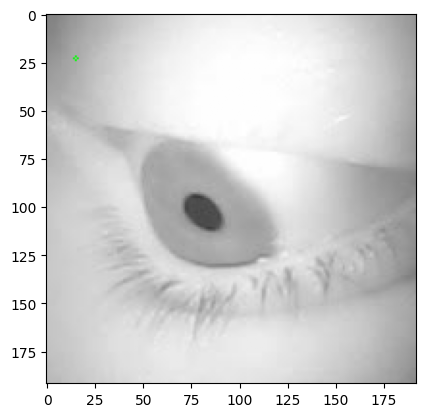

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


center_out: [12, 22] center_label: [12, 22]


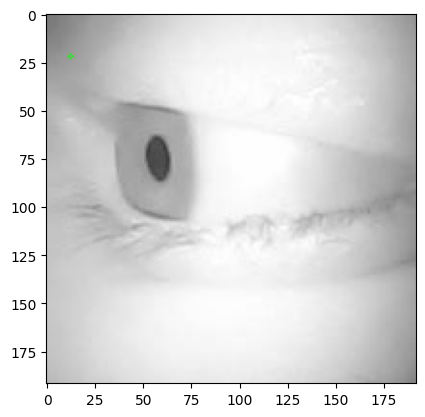

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


center_out: [17, 24] center_label: [17, 24]


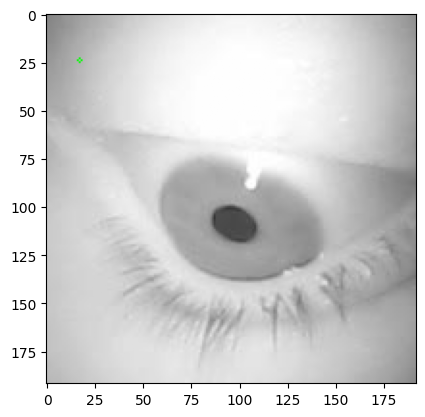

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


center_out: [23, 25] center_label: [23, 25]


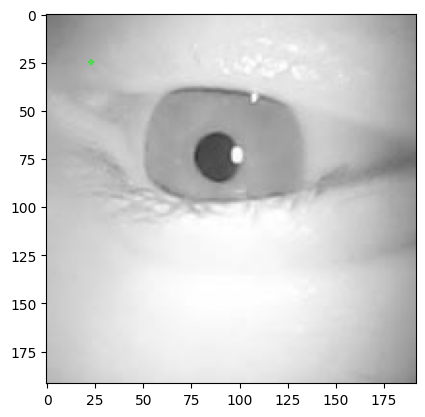

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


center_out: [16, 22] center_label: [16, 23]


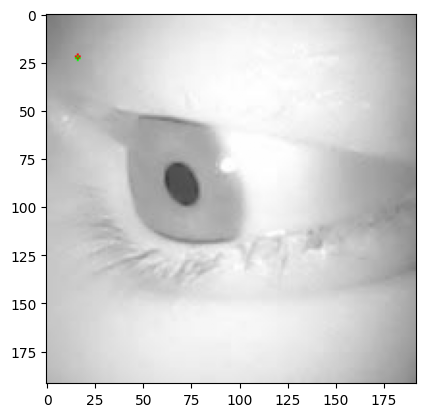

center_out: [18, 23] center_label: [18, 23]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


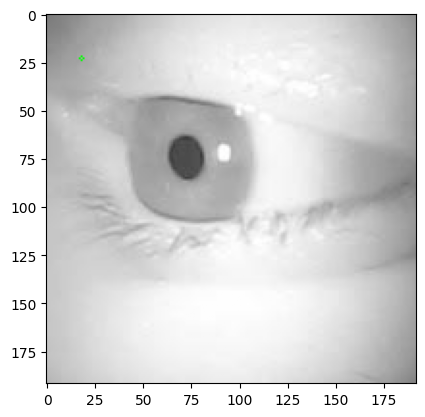

In [22]:
visualize(model_corneal, dataloaders["test"] ,device, 50)

In [ ]:
#TODO 3 NN system